In [1]:
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
import pickle
from scipy.integrate import solve_ivp

In [30]:
def target_hamiltonian(parameters):

    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    rabi_freq__N = rabi_freq/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm

    H_qubit_target = .5*(qubit_detuning_lamb_shift__N*sigmaz() + rabi_freq__N*sigmax())
    return H_qubit_target

def coherent_state_dynamics(t, initial_state, cavity_drive_amplitude, cavity_freq, cavity_diss_rate, N):
    cavity_field = cavity_drive_amplitude/(-(cavity_freq) + .5j*cavity_diss_rate)
    cavity_state = coherent(N, cavity_field)
    rho_cavity = cavity_state @ cavity_state.dag()
    tdynamics = np.exp(-1j*(cavity_freq*t)-cavity_diss_rate*t/2)
    return initial_state*tdynamics + rho_cavity*(1-tdynamics)

def coherent_field_dynamics(t, initial_state, cavity_drive_amplitude, cavity_freq, cavity_diss_rate, N):
    cavity_field = cavity_drive_amplitude/(-(cavity_freq) + .5j*cavity_diss_rate)
    tdynamics = np.exp(-1j*(cavity_freq*t)-cavity_diss_rate*t/2)
    return initial_state*tdynamics + cavity_field*(1-tdynamics)

In [60]:

def plot_dynamics_comparison(tlist, dynamics_dict, params_text, max_time=None):
    """
    Plot comparison of different dynamics methods
    
    Parameters:
    tlist: time array
    dynamics_dict: dictionary with keys and corresponding dynamics objects
                  e.g., {'Hamiltonian 7': full_dynamics, 'Redfield': redfield_dynamics, ...}
    max_time: maximum time to plot (uses max(tlist) if None)
    """
    
    # Determine time range to plot
    if max_time is None:
        max_time = max(tlist)
    
    time_mask = tlist <= max_time
    tlist_plot = tlist[time_mask]
    
    # Create plot - now 3 subplots instead of 2
    fig, axes = plt.subplots(3, 1, figsize=(4, 8))
    
    # Define colors for different methods
    colors = {
        'Hamiltonian 7': '#000080',
        'Redfield': '#008000', 
        'Rates': '#800000',
        'Time-dep Redfield': '#FFA500'
    }
    
    # Plot each method
    for label, dynamics in dynamics_dict.items():
        color = colors.get(label, None)
        
        # Calculate expectations (handle both system and combined Hilbert spaces)
        if hasattr(dynamics[0], 'dims') and dynamics[0].dims == [[N,2],[N,2]]:
            # Combined Hilbert space (cavity + qubit)
            x_exp = expect(tensor(qeye(N), sigmax()), dynamics)
            z_exp = expect(tensor(qeye(N), sigmaz()), dynamics)
            # Calculate cavity photon number expectation
            cavity_number_op = tensor(destroy(N).dag() * destroy(N), qeye(2))
            cavity_exp = expect(cavity_number_op, dynamics)
        else:
            # Qubit only - no cavity information available
            x_exp = expect(sigmax(), dynamics)
            z_exp = expect(sigmaz(), dynamics)
            cavity_exp = np.zeros_like(x_exp)  # Placeholder
        
        # Plot qubit expectations
        axes[0].plot(tlist_plot, x_exp[time_mask], color=color, label=label)
        axes[1].plot(tlist_plot, z_exp[time_mask], color=color, label=label)
        
        # Plot cavity photon number (only for methods with cavity information)
        if hasattr(dynamics[0], 'dims') and dynamics[0].dims == [[N,2],[N,2]]:
            axes[2].plot(tlist_plot, cavity_exp[time_mask], color=color, label=label)
    
    # Format σ_x plot
    axes[0].set_ylabel(r'$\langle\sigma_x\rangle$')
    axes[0].legend(fontsize=8)
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].grid(True, alpha=0.3)
    
    # Format σ_z plot  
    axes[1].set_ylabel(r'$\langle\sigma_z\rangle$')
    axes[1].legend(fontsize=8)
    axes[1].set_ylim(-1.1, 1.1)
    axes[1].grid(True, alpha=0.3)
    
    # Format cavity photon number plot
    axes[2].set_ylabel(r'$\langle a^\dagger a \rangle$')
    axes[2].set_xlabel('Time (μs)')
    axes[2].legend(fontsize=8)
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(' | '.join(params_text), y=0.98)
    plt.tight_layout()
    
    return fig, axes

In [ ]:
### See dynamics in polaron frame.

def lindblad_master_equation(t, rho_vec, hamiltonian, L_operators):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)

    L_conj = np.conj(L_operators)

    term1 = np.einsum('nij, jk, nlk', L_operators, rho, L_conj)
    term2 = np.einsum('nji, njk, kl', L_conj, L_operators, rho)
    term3 = np.einsum('ij, nkj, nkl', rho, L_conj, L_operators)

    lindblad_part = term1 - .5*(term2 + term3)

    coherent_part = -1j*(np.einsum('ij,jk',hamiltonian, rho) - np.einsum('ij,jk', rho, hamiltonian))

    drho = coherent_part + lindblad_part
    return drho.flatten()


def calculate_full_dynamics(parameters):
    
    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm

    ### HAMILTONIAN 7 ####
    d = tensor(destroy(N), qeye(2))   
    sz = tensor(qeye(N), sigmaz())  
    sx = tensor(qeye(N), sigmax())     
    sm = tensor(qeye(N), sigmam()) 

    H_cav = cavity_detuning__N * d.dag()*d + cavity_drive_amplitude__N * (d + d.dag())
    H_qubit = .5*(qubit_detuning__N + eff_coupling__N)*sz + .5*rabi_freq__N*sx
    H_int =   eff_coupling__N*d.dag()*d*sz
    H = H_cav + H_qubit + H_int

    H_matrix = H.full()
    d_matrix = d.full()


    dissipation_channels = [(cavity_diss_rate__N**.5*d_matrix)]

    psi0_cavity = coherent(N,cavity_field)
    initial_state = tensor(psi0_cavity, psi0_atom)
    rho0 = initial_state@initial_state.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()

    max_step =  0.05/np.max([cavity_drive_amplitude__N, qubit_detuning__N, cavity_detuning__N,
                            rabi_freq__N, eff_coupling__N, cavity_diss_rate__N])

    sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                     t_eval=tlist__N, max_step=max_step, args=(H_matrix, dissipation_channels))

    full_dynamics = sol.y.T.reshape(time_steps, 2*N, 2*N)

    dynamics = [Qobj(i, dims=[[N, 2], [N, 2]]) for i in full_dynamics]

    return dynamics







In [81]:
N = 10
cavity_diss_rate = 2*np.pi*4.3*10**6
input_power = 0
rabi_freq = 2*np.pi*20*10**6
eff_coupling = 2*np.pi*(5)*10**6
qubit_targetz = 10*2*np.pi*10**6
norm = eff_coupling
final_time__mus = 0.002
time_steps = 1000
tlist = np.linspace(0, final_time__mus, time_steps)

parameters = {"N":N,
            "final_time__mus": final_time__mus,
            "time_steps": time_steps,
            "input_power": input_power,
            "rabi_freq": rabi_freq,
            "eff_coupling": eff_coupling,
            "qubit_targetz": qubit_targetz,
            "cavity_diss_rate": cavity_diss_rate,
            "norm": norm}

H_qubit_target = target_hamiltonian(parameters)
eigenenergies, eigenstate = H_qubit_target.eigenstates()
psi0_atom = eigenstate[-1]
target_state = eigenstate[0]

parameters["initial_state_qubit"] = psi0_atom

In [82]:
full_dynamics = calculate_full_dynamics(parameters)

(<Figure size 400x800 with 3 Axes>,
 array([<Axes: ylabel='$\\langle\\sigma_x\\rangle$'>,
        <Axes: ylabel='$\\langle\\sigma_z\\rangle$'>,
        <Axes: xlabel='Time (μs)', ylabel='$\\langle a^\\dagger a \\rangle$'>],
       dtype=object))

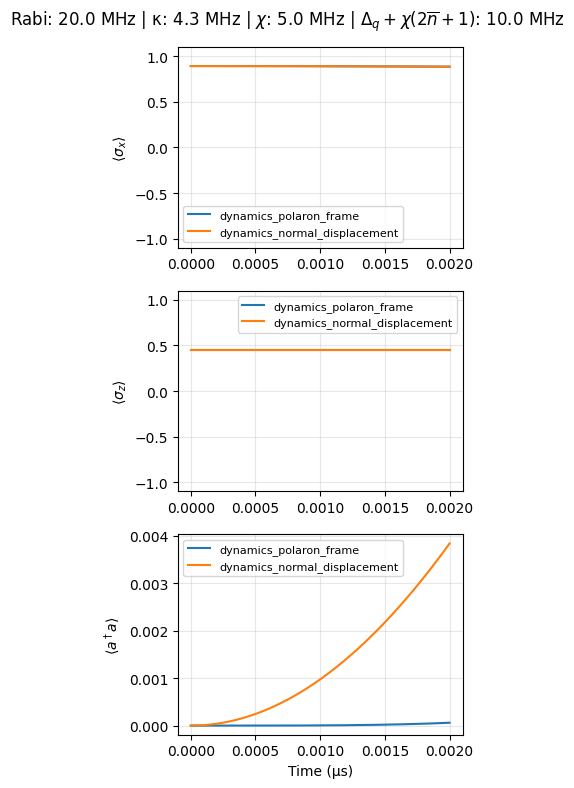

In [83]:
cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

# Non-polaron cavity state
cavity_state_np = coherent(N, cavity_field)
rho_cavity_np = cavity_state_np @ cavity_state_np.dag()

# Calculate the other two cavity fields
cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

cavity_e_t = np.array([coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning + eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])
cavity_g_t = np.array([coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning - eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])


projector_e = basis(2,0)*basis(2,0).dag()
projector_g = basis(2,1)*basis(2,1).dag()
displace_e_t = [displace(N, i) for i in cavity_e_t]
displace_g_t = [displace(N, i) for i in cavity_g_t]
polaron_trafo = [tensor(displace_e_t[i],projector_e) + tensor(displace_g_t[i],projector_g) for i in range(len(tlist))]

dynamics_polaron_frame = [polaron_trafo[i].dag()*full_dynamics[i]*polaron_trafo[i] for i in range(len(tlist))]

displace_np = tensor(displace(N, cavity_field),qeye(2))
dynamics_normal_displace = [displace_np.dag()*i*displace_np for i in full_dynamics]


dynamics_dict = {"dynamics_polaron_frame":dynamics_polaron_frame,
                 "dynamics_normal_displacement": dynamics_normal_displace}
params_text = []

params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f} MHz")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f} MHz")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f} MHz")
params_text.append(r"$\Delta_q+\chi (2\overline{n}+1)$"+f": {qubit_targetz/(2*np.pi*1e6):.1f} MHz")

plot_dynamics_comparison(tlist, dynamics_dict, params_text, max_time=None)

In [ ]:
cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

# Non-polaron cavity state
cavity_state_np = coherent(N, cavity_field)
rho_cavity_np = cavity_state_np @ cavity_state_np.dag()

# Calculate the other two cavity fields
cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

cavity_e_t = np.array([coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning + eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])
cavity_g_t = np.array([coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning - eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])

beta = cavity_e_t - cavity_g_t 

B_polaron_frame = (beta*np.conj(cavity_drive_amplitude) + np.conj(beta)*cavity_drive_amplitude)/2 + cavity_diss_rate*np.imag(cavity_g_t*np.conj(cavity_e_t))
gamma_polaron_frame = cavity_diss_rate*beta*np.conj(beta)

d = tensor(destroy(N), qeye(2))
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sm = tensor(qeye(N), sigmam()) 

d_full = d.full()
sz_full = sz.full()
sm_full = sm.full()


tlist__N = tlist*norm
cavity_detuning__N = cavity_detuning/norm
cavity_drive_amplitude__N = cavity_drive_amplitude/norm
qubit_detuning__N = qubit_detuning/norm
eff_coupling__N = eff_coupling/norm
rabi_freq__N = rabi_freq/norm
cavity_diss_rate__N = cavity_diss_rate/norm
qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
B_polaron_frame__N = B_polaron_frame

#H_constant_part
qubit_term = (qubit_detuning__N + eff_coupling__N )*sz/2 
cavity_term = cavity_detuning__N*d.dag()*d
coupling_term = eff_coupling__N*sz*d.dag()*d 
H_const = (qubit_term + cavity_term + coupling_term).full()



def polaron_frame_master_equation(t, rho_vec):
    cavity_e_t = coherent_field_dynamics(t, cavity_field, cavity_drive_amplitude__N, 
                                        cavity_detuning__N + eff_coupling__N, cavity_diss_rate__N, N)
    cavity_g_t = coherent_field_dynamics(t, cavity_field, cavity_drive_amplitude__N, 
                                               cavity_detuning - eff_coupling__N, cavity_diss_rate__N, N)
    
    displace_e_t = tensor(displace(N, cavity_e_t), qeye(2))
    displace_g_t = tensor(displace(N, cavity_g_t), qeye(2))
 
    rabi_term = rabi_freq__N*(sm*displace_g_t.dag()*displace_e_t + sm.dag()*displace_e_t.dag()*displace_g_t).full()

    beta = cavity_e_t - cavity_g_t 

    B_polaron_frame__N = (beta*np.conj(cavity_drive_amplitude__N) + np.conj(beta)*cavity_drive_amplitude__N)/2 + cavity_diss_rate__N*np.imag(cavity_g_t*np.conj(cavity_e_t))
    gamma_polaron_frame__N = cavity_diss_rate__N*beta*np.conj(beta)


    lamb_shift_term = (B_polaron_frame__N*sz/2).full()
    hamiltonian = H_const + rabi_term + lamb_shift_term

    dim = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(dim, dim)

    L_operators = [(gamma_polaron_frame__N/4)**.5*sz_full, cavity_diss_rate__N**.5*d_full]

    L_conj = np.conj(L_operators)

    term1 = np.einsum('nij, jk, nlk', L_operators, rho, L_conj)
    term2 = np.einsum('nji, njk, kl', L_conj, L_operators, rho)
    term3 = np.einsum('ij, nkj, nkl', rho, L_conj, L_operators)

    lindblad_part = term1 - .5*(term2 + term3)

    coherent_part = -1j*(np.einsum('ij,jk',hamiltonian, rho) - np.einsum('ij,jk', rho, hamiltonian))

    extra_term1 = (cavity_diss_rate__N*beta/2)*(np.einsum('ij,jk,kl',sz_full, rho, np.conj(d_full.T)) - np.einsum('ij,jk,kl', rho, sz_full, np.conj(d_full.T)))
    extra_term2 = (cavity_diss_rate__N*np.conj(beta)/2)*(np.einsum('ij,jk,kl', d_full, sz_full, rho, ) - np.einsum('ij,jk,kl', d_full, rho, sz_full))
    

    drho = coherent_part + lindblad_part + extra_term1 + extra_term2

    return drho.flatten()

psi0_cavity = coherent(N,cavity_field)
initial_state = tensor(psi0_cavity, psi0_atom)
rho0 = initial_state@initial_state.dag()

cavity_e_initial = coherent_field_dynamics(0, cavity_field, cavity_drive_amplitude__N, 
                                               cavity_detuning__N + eff_coupling__N, cavity_diss_rate__N, N)
cavity_g_initial = coherent_field_dynamics(0, cavity_field, cavity_drive_amplitude__N, 
                                               cavity_detuning__N - eff_coupling__N, cavity_diss_rate__N, N)

projector_e = basis(2,0)*basis(2,0).dag()
projector_g = basis(2,1)*basis(2,1).dag()
displace_e_initial = displace(N, cavity_e_initial)
displace_g_initial = displace(N, cavity_g_initial)
polaron_trafo = tensor(displace_e_initial,projector_e) + tensor(displace_g_initial,projector_g) 
rho0_polaron = polaron_trafo.dag()*rho0*polaron_trafo
rho0_matrix = rho0_polaron.full()
rho0_vectorized = rho0_matrix.flatten()

max_step =  0.05/np.max([cavity_drive_amplitude__N, qubit_detuning__N, cavity_detuning__N,
                        rabi_freq__N, eff_coupling__N, cavity_diss_rate__N])

sol = solve_ivp(polaron_frame_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                    t_eval=tlist__N, max_step=max_step)

full_dynamics = sol.y.T.reshape(time_steps, 2*N, 2*N)

dynamics = [Qobj(i, dims=[[N, 2], [N, 2]]) for i in full_dynamics]


In [ ]:
dynamics_dict = {"dynamics_polaron_frame1":dynamics_polaron_frame,
                 "dynamics_polaron_frame2":dynamics,
                 "dynamics_normal_displacement": dynamics_normal_displace}
params_text = []

params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f} MHz")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f} MHz")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f} MHz")
params_text.append(r"$\Delta_q+\chi (2\overline{n}+1)$"+f": {qubit_targetz/(2*np.pi*1e6):.1f} MHz")

plot_dynamics_comparison(tlist, dynamics_dict, params_text, max_time=None)

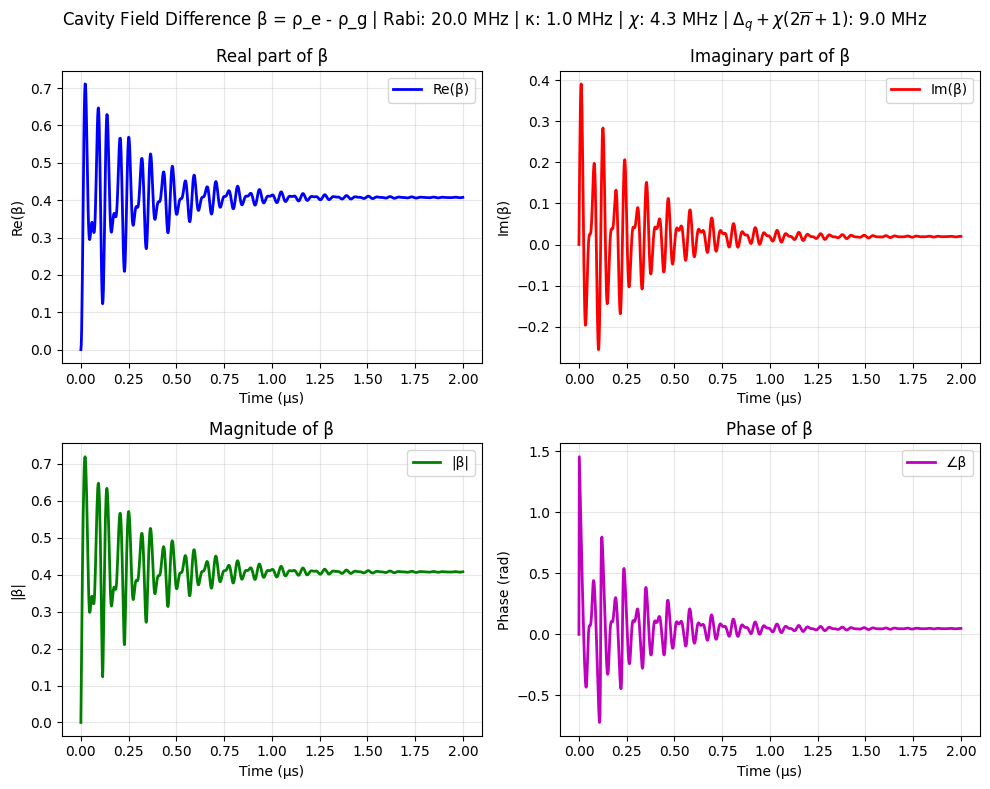

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot real and imaginary parts of beta
axes[0,0].plot(tlist, beta.real, 'b-', linewidth=2, label='Re(β)')
axes[0,0].set_ylabel('Re(β)')
axes[0,0].set_xlabel('Time (μs)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_title('Real part of β')

axes[0,1].plot(tlist, beta.imag, 'r-', linewidth=2, label='Im(β)')
axes[0,1].set_ylabel('Im(β)')
axes[0,1].set_xlabel('Time (μs)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_title('Imaginary part of β')

# Plot magnitude and phase
beta_mag = np.abs(beta)
beta_phase = np.angle(beta)

axes[1,0].plot(tlist, beta_mag, 'g-', linewidth=2, label='|β|')
axes[1,0].set_ylabel('|β|')
axes[1,0].set_xlabel('Time (μs)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_title('Magnitude of β')

axes[1,1].plot(tlist, beta_phase, 'm-', linewidth=2, label='∠β')
axes[1,1].set_ylabel('Phase (rad)')
axes[1,1].set_xlabel('Time (μs)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_title('Phase of β')

# Add parameter text
params_text = []
params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f} MHz")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f} MHz")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f} MHz")
params_text.append(r"$\Delta_q+\chi (2\overline{n}+1)$" + f": {qubit_targetz/(2*np.pi*1e6):.1f} MHz")


plt.suptitle('Cavity Field Difference β = ρ_e - ρ_g | ' + ' | '.join(params_text), y=0.98)
plt.tight_layout()